# Previsão de Chuva - Classificação (Abordagem 3)

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
import seaborn as sns

In [2]:
import sys
import os

# Adicionar src/ ao path do Python
sys.path.append(os.path.abspath('../src'))

# Agora o import funciona
from data_prep import prep_data

# 1 - Processamento de Dados

## 1.1 - Criação dos Dataframes
Função que faz todo o tratamento dos arquivos de entrada e gera dois Dataframes, um com os dados de entrada, e outro com os dados de saída.\
Código completo no arquivo `data_prep.py`

In [3]:
df_in, df_out = prep_data()

## 1.2 - Separação em Quadrimestres
Reorganizamos os dataframes em Quadrimestres em vez de Meses, agregando os dados.\
Nessa abordagem, usamos a média (`mean`) dos atributos de entrada, e a soma (`sum`) da precipitação total.

In [4]:
# Criar cópias dos dataframes originais para evitar modificações diretas
df_in_copy = df_in.copy()
df_out_copy = df_out.copy()

# Função para identificar o quadrimestre
def assign_quad(month):
    if month in [1, 2, 3, 4]:
        return 1
    elif month in [5, 6, 7, 8]:
        return 2
    elif month in [9, 10, 11, 12]:
        return 3

# Adicionar a coluna de quadrimestre
df_in_copy['QUAD'] = df_in_copy['MON'].apply(assign_quad)
df_out_copy['QUAD'] = df_out_copy['MON'].apply(assign_quad)

# Remover a coluna "MON" após criar "QUAD"
df_in_copy = df_in_copy.drop(columns=['MON'])
df_out_copy = df_out_copy.drop(columns=['MON'])  # Se aplicável

# Filtrar os dados de entrada e saída para incluir apenas anos de 1982 a 2023
df_in_copy = df_in_copy[(df_in_copy['YEAR'] >= 1982) & (df_in_copy['YEAR'] <= 2023)]
df_out_copy = df_out_copy[(df_out_copy['YEAR'] >= 1982) & (df_out_copy['YEAR'] <= 2023)]

# Função para calcular próximo quadrimestre
def proximo_quadrimestre(row):
    year = row['YEAR']
    quad = row['QUAD']
    if quad == 3:
        return pd.Series({'NEXT_YEAR': year + 1, 'NEXT_QUAD': 1})
    else:
        return pd.Series({'NEXT_YEAR': year, 'NEXT_QUAD': quad + 1})

# Adicionar colunas de próximo quadrimestre
df_in_copy[['NEXT_YEAR', 'NEXT_QUAD']] = df_in_copy.apply(proximo_quadrimestre, axis=1)

# Agregar dados de entrada (média) e saída (soma)
aggregated_in = df_in_copy.groupby(['YEAR', 'QUAD']).mean().reset_index()
aggregated_out = df_out_copy.groupby(['YEAR', 'QUAD'])['PRECIP'].sum().reset_index()

# Renomear colunas do target
aggregated_out_renamed = aggregated_out.rename(
    columns={'YEAR': 'NEXT_YEAR', 'QUAD': 'NEXT_QUAD', 'PRECIP': 'PRECIP_NEXT_QUAD'}
)

# Mesclar dados
aggregated_data = pd.merge(
    aggregated_in,
    aggregated_out_renamed,
    on=['NEXT_YEAR', 'NEXT_QUAD'],
    how='inner'
)

In [5]:
#aggregated_data

# 2 - Códigos de Preparação

## 2.1 - Definição das Classses

In [6]:
# Definir os thresholds de classificação
LOW_THRESHOLD = 300   # Baixa precipitação
HIGH_THRESHOLD = 600  # Alta precipitação

# Função de classificação com 3 categorias
def classify_precipitation(precip):
    if precip < LOW_THRESHOLD:
        return 'Baixa Precipitação'
    elif LOW_THRESHOLD <= precip <= HIGH_THRESHOLD:
        return 'Moderada Precipitação'
    else:
        return 'Alta Precipitação'

# Aplicar a nova classificação
aggregated_data['Precip_Class'] = aggregated_data['PRECIP_NEXT_QUAD'].apply(classify_precipitation)

# Mapear para valores numéricos
label_mapping = {
    'Baixa Precipitação': 0,
    'Moderada Precipitação': 1,
    'Alta Precipitação': 2
}
aggregated_data['Precip_Class'] = aggregated_data['Precip_Class'].map(label_mapping)

# Exibir o dataframe resultante
aggregated_data

,YEAR,QUAD,1_TW_CP,2_DarwinPr,3_TW_EP,4_TahitiPr,5_TW_WP,6_NATL,6_SATL,6_TROP,7_NINO1+2,7_NINO3,7_NINO4,7_NINO3.4,NEXT_YEAR,NEXT_QUAD,PRECIP_NEXT_QUAD,Precip_Class
0,1982,1,8.000,7.725,10.025,12.150,0.650,25.4375,26.0300,27.8225,24.8625,26.6350,28.1975,27.0275,1982.0,2.0,991.126667,2
1,1982,2,6.275,13.750,9.425,12.600,-0.625,26.6275,23.6575,27.6200,22.6650,26.7475,29.0275,28.0125,1982.0,3.0,243.956667,0
2,1982,3,0.550,11.725,6.225,10.800,-2.125,26.8950,23.2125,27.5850,23.6775,27.2500,28.9200,28.4650,1983.0,1.0,609.933333,2
3,1983,1,0.975,10.075,3.700,8.700,1.350,25.7350,26.2875,28.2425,27.7275,28.5000,28.5550,28.5450,1983.0,2.0,659.611905,2
4,1983,2,6.750,13.375,6.325,14.450,3.425,26.8975,23.8275,27.8100,26.1225,27.2650,28.6025,27.5375,1983.0,3.0,244.042857,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,2022,1,11.600,7.350,10.575,13.150,4.725,25.9875,26.9725,27.9750,24.6850,25.7400,27.8100,26.2350,2022.0,2.0,1282.361905,2
121,2022,2,10.975,11.850,9.850,15.125,6.625,27.3225,24.6975,27.6675,21.4825,25.6300,27.9650,26.6150,2022.0,3.0,311.586905,1
122,2022,3,11.375,8.700,10.450,14.250,4.975,27.8000,24.1250,27.3400,20.3325,24.2925,27.6875,25.8625,2023.0,1.0,547.216667,1
123,2023,1,11.050,7.200,9.900,12.125,3.725,26.0025,26.9050,28.1950,26.8425,26.7400,28.0250,26.8475,2023.0,2.0,937.335119,2


## 2.2 - Lista de Modelos

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

lista_modelos = [
    # =========================================================
    # 1. Random Forest
    # =========================================================
    {
        "nome_do_modelo": "Random Forest",
        "estimador": Pipeline([
            ('scaler', StandardScaler()), 
            ('pca', PCA()),
            ('classifier', RandomForestClassifier(random_state=42))
        ]),
        "parametros": {
            'pca__n_components': [2, 3, 4],          # Componentes do PCA
            'classifier__n_estimators': [50, 100],   # Número de árvores
            'classifier__max_depth': [None, 10, 20], # Profundidade máxima
            'classifier__min_samples_split': [2, 5]  # Divisão mínima
        }
    },

    # =========================================================
    # 2. Regressão Logística
    # =========================================================
    {
        "nome_do_modelo": "Logistic Regression",
        "estimador": Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('classifier', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "parametros": {
            'pca__n_components': [2, 3],             
            'classifier__C': [0.1, 1, 10],           # Regularização
            'classifier__penalty': ['l2', 'l1'],     
            'classifier__solver': ['liblinear']       # Solver compatível com L1/L2
        }
    },

    # =========================================================
    # 3. MLP (Multi-Layer Perceptron)
    # =========================================================
    {
        "nome_do_modelo": "MLP",
        "estimador": Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('classifier', MLPClassifier(random_state=42, early_stopping=True))
        ]),
        "parametros": {
            'pca__n_components': [3, 4],             
            'classifier__hidden_layer_sizes': [(50,), (100,)], # Camadas ocultas
            'classifier__activation': ['relu', 'tanh'], 
            'classifier__alpha': [0.0001, 0.001]     # Regularização L2
        }
    },

    # =========================================================
    # 4. KNN (K-Nearest Neighbors)
    # =========================================================
    {
        "nome_do_modelo": "KNN",
        "estimador": Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('classifier', KNeighborsClassifier())
        ]),
        "parametros": {
            'pca__n_components': [2, 3],             
            'classifier__n_neighbors': [3, 5, 7],    # Número de vizinhos
            'classifier__weights': ['uniform', 'distance'] 
        }
    },

    # =========================================================
    # 5. SVM (Support Vector Machine)
    # =========================================================
    {
        "nome_do_modelo": "SVM",
        "estimador": Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('classifier', SVC(random_state=42, probability=True)) # probability=True para ROC
        ]),
        "parametros": {
            'pca__n_components': [2, 3],             
            'classifier__C': [0.1, 1, 10],           # Penalidade de erro
            'classifier__kernel': ['rbf', 'linear'], 
            'classifier__gamma': ['scale', 'auto']   
        }
    }
]

# 3 - Treinamento

In [8]:
from multiclass_train_util import nested_cross_validation_grid_search

# Separar features e target (excluindo metadados temporais)
X = aggregated_data.drop(columns=[
    'Precip_Class', 'YEAR', 'QUAD', 'NEXT_YEAR', 'NEXT_QUAD', 'PRECIP_NEXT_QUAD'
])
y = aggregated_data['Precip_Class']

# Chamar a função de validação cruzada com os dados processados
resultados_gerais = nested_cross_validation_grid_search(
    lista_modelos=lista_modelos,
    X=X,
    y=y,
    k_folds_outer=5,
    k_folds_inner=3
)




 **** RESULTADO DOS MODELOS ****

Número de classes identificadas: 3
Classes: [0 1 2]

Treinando modelo Random Forest 1.
Matriz de Confusão - Fold 1:
[[4 2 0]
 [1 2 3]
 [0 4 9]]
2.
Matriz de Confusão - Fold 2:
[[ 3  0  3]
 [ 2  3  1]
 [ 0  3 10]]
3.
Matriz de Confusão - Fold 3:
[[ 5  0  0]
 [ 2  3  2]
 [ 0  2 11]]
4.
Matriz de Confusão - Fold 4:
[[ 5  0  1]
 [ 2  3  2]
 [ 0  2 10]]
5.
Matriz de Confusão - Fold 5:
[[2 3 1]
 [1 2 4]
 [0 4 8]]

-- Processando resultados finais --

Resultados para Random Forest:
 - Acurácia   : 0.6400 +/- 0.0980
 - Precisão   : 0.6509 +/- 0.0793
 - Revocação  : 0.6400 +/- 0.0980
 - F1-Score   : 0.6386 +/- 0.0905
 - Tempo médio: 4.07 segundos

Treinando modelo Logistic Regression 1.
Matriz de Confusão - Fold 1:
[[ 6  0  0]
 [ 1  2  3]
 [ 0  2 11]]
2.
Matriz de Confusão - Fold 2:
[[ 5  1  0]
 [ 2  3  1]
 [ 0  2 11]]
3.
Matriz de Confusão - Fold 3:
[[ 5  0  0]
 [ 3  3  1]
 [ 0  3 10]]
4.
Matriz de Confusão - Fold 4:
[[ 5  1  0]
 [ 1  3  3]
 [ 0  1 11]]
5.


# 4 - Resultados

In [9]:
# Converter os resultados para DataFrame
df_resultados = pd.DataFrame(resultados_gerais).T.reset_index()
df_resultados = df_resultados.rename(columns={'index': 'Modelo'})

# Selecionar colunas relevantes para análise de performance
colunas = [
    'Modelo',
    'f1_mean',          # Média harmônica entre precisão e revocação
    'accuracy_mean',    # Taxa geral de acertos
    'precision_mean',   # Precisão das previsões positivas
    'recall_mean'      # Taxa de identificação dos casos positivos
]
df_comparacao = df_resultados[colunas]

df_comparacao

,Modelo,f1_mean,accuracy_mean,precision_mean,recall_mean
0,Random Forest,0.638552,0.64,0.65091,0.64
1,Logistic Regression,0.701196,0.712,0.70214,0.712
2,MLP,0.630618,0.64,0.644159,0.64
3,KNN,0.678577,0.672,0.700444,0.672
4,SVM,0.735857,0.736,0.751271,0.736


<Figure size 1000x600 with 0 Axes>

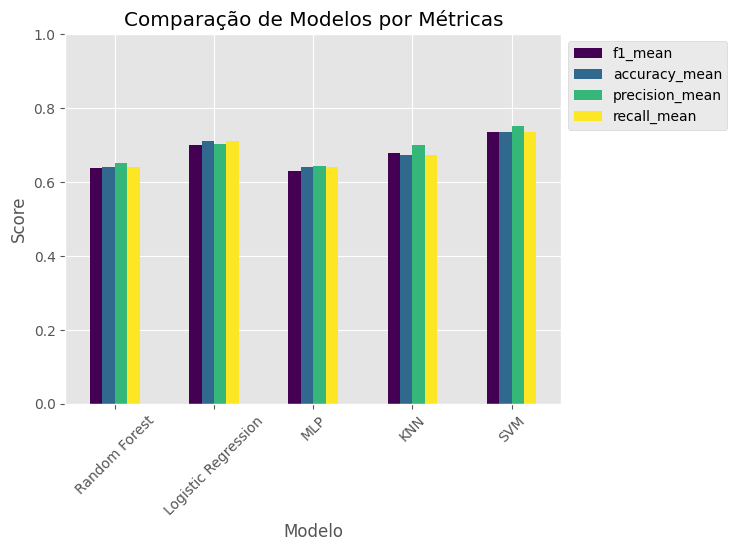

In [10]:
# Configurar o gráfico
plt.figure(figsize=(10, 6))
df_comparacao.set_index('Modelo').plot(kind='bar', rot=45, colormap='viridis')
plt.title('Comparação de Modelos por Métricas')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [11]:
# Converter os resultados para DataFrame e preparar para análise
df_resultados = pd.DataFrame(resultados_gerais).T.reset_index()
df_resultados = df_resultados.rename(columns={'index': 'Modelo'})

# Selecionar métricas relevantes para avaliação dos modelos
colunas = [
    'Modelo',           # Nome do classificador
    'f1_mean',          # Equilíbrio entre precisão e revocação 
    'accuracy_mean',    # Proporção total de acertos
    'precision_mean',   # Confiabilidade das previsões positivas
    'recall_mean'       # Capacidade de identificar casos positivos
]
df_comparacao = df_resultados[colunas].copy()

# Garantir que todas as métricas sejam numéricas para comparação adequada
colunas_numericas = ['f1_mean', 'accuracy_mean', 'precision_mean', 'recall_mean']

for coluna in colunas_numericas:
    # Converter métricas para formato numérico com tratamento de erros
    df_comparacao[coluna] = pd.to_numeric(df_comparacao[coluna], errors='coerce')
    
    # Identificar e reportar possíveis problemas nos dados
    if df_comparacao[coluna].isnull().any():
        print(f"\nAtenção: Detectados valores inválidos na métrica {coluna}")
        print("Registros problemáticos:")
        print(df_comparacao[df_comparacao[coluna].isnull()])

# Registrar estado inicial para verificação
print("\nClassificação inicial dos modelos:")
for _, row in df_comparacao[['Modelo', 'f1_mean']].iterrows():
    print(f"{row['Modelo']}: {row['f1_mean']:.4f}")

# Ordenar modelos pelo F1-score (métrica principal de avaliação)
df_comparacao = df_comparacao.sort_values(
    by='f1_mean',
    ascending=False,
    na_position='last'  # Valores inválidos são posicionados ao final
)

# Verificar resultado da ordenação
print("\nTop 3 modelos após ordenação:")
top3 = df_comparacao[['Modelo', 'f1_mean']].head(3)
for _, row in top3.iterrows():
    print(f"{row['Modelo']}: {row['f1_mean']:.4f}")

# Validar integridade da ordenação
print("\nValidação da ordenação:")
valores_ordenados = df_comparacao['f1_mean'].tolist()
if valores_ordenados == sorted(valores_ordenados, reverse=True):
    print("✓ Ordenação correta confirmada")
else:
    print("⚠ Inconsistência detectada na ordenação")
    print(f"Sequência atual: {valores_ordenados}")
    print(f"Sequência esperada: {sorted(valores_ordenados, reverse=True)}")

# Apresentar quadro comparativo completo
print("\n=== Comparativo Detalhado dos Modelos ===")
df_formatado = df_comparacao.copy()
for col in colunas_numericas:
    df_formatado[col] = df_formatado[col].map('{:.4f}'.format)

print(df_formatado.to_string(index=False))

# Identificar e validar o melhor modelo
melhor_modelo = df_comparacao.iloc[0]['Modelo']
melhor_f1 = df_comparacao.iloc[0]['f1_mean']
melhor_accuracy = df_comparacao.iloc[0]['accuracy_mean']
melhor_precision = df_comparacao.iloc[0]['precision_mean']
melhor_recall = df_comparacao.iloc[0]['recall_mean']

print(f"\nMelhor Modelo: {melhor_modelo}")
print(f"Performance:")
print(f"- F1-Score: {melhor_f1:.4f}")
print(f"- Accuracy: {melhor_accuracy:.4f}")
print(f"- Precision: {melhor_precision:.4f}")
print(f"- Recall: {melhor_recall:.4f}")

# Verificação final de consistência
if len(df_comparacao) > 1:
    segundo_melhor_f1 = df_comparacao.iloc[1]['f1_mean']
    if melhor_f1 < segundo_melhor_f1:
        print("\n⚠ ALERTA: Inconsistência na classificação detectada!")
        print(f"F1-Score do primeiro modelo ({melhor_f1:.4f}) é inferior ao segundo ({segundo_melhor_f1:.4f})")
        print("Recomenda-se verificar os dados e critérios de ordenação.")


Classificação inicial dos modelos:
Random Forest: 0.6386
Logistic Regression: 0.7012
MLP: 0.6306
KNN: 0.6786
SVM: 0.7359

Top 3 modelos após ordenação:
SVM: 0.7359
Logistic Regression: 0.7012
KNN: 0.6786

Validação da ordenação:
✓ Ordenação correta confirmada

=== Comparativo Detalhado dos Modelos ===
             Modelo f1_mean accuracy_mean precision_mean recall_mean
                SVM  0.7359        0.7360         0.7513      0.7360
Logistic Regression  0.7012        0.7120         0.7021      0.7120
                KNN  0.6786        0.6720         0.7004      0.6720
      Random Forest  0.6386        0.6400         0.6509      0.6400
                MLP  0.6306        0.6400         0.6442      0.6400

Melhor Modelo: SVM
Performance:
- F1-Score: 0.7359
- Accuracy: 0.7360
- Precision: 0.7513
- Recall: 0.7360
